Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (resnet_block): ResNet(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1   

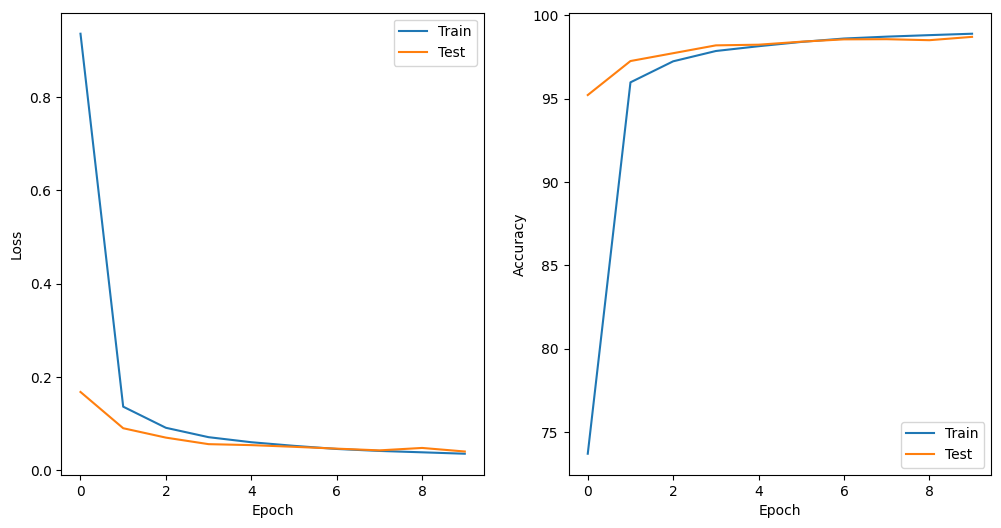

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary


class ResNet(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)


        self.resnet_block = ResNet(16, 16)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)

        # self.fc1 = nn.Linear(16 * 4 * 4, 120)
        # self.resnet_block = ResNet(120, 120)
        
        
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))


        x = self.resnet_block(x)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))

        # x = x.view(-1, 16 * 4 * 4)
        # x = F.relu(self.fc1(x))
        # x = self.resnet_block(x.view(-1, 120, 1, 1)).view(-1, 120)



        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
print(model)


summary(model, (1, 28, 28))


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10): 
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)
    print(f'Epoch {epoch + 1}, train:: loss: {(running_loss / len(trainloader)):.4f}, accuracy: {(100 * correct / total):.4f}%  ',end="")


    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_losses.append(running_loss / len(testloader))
    test_accuracies.append(100 * correct / total)
    print(f'test:: loss: {(running_loss / len(testloader)):.4f}, accuracy: {(100 * correct / total):.4f}%')



class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))



plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()